In [1]:
import random
import numpy as np

import matplotlib.pyplot as plt

import warnings 

from sklearn.datasets import make_swiss_roll, make_blobs, load_digits
from sklearn import decomposition
from sklearn.manifold import TSNE

In [2]:
%matplotlib inline
# %config InlineBackend.figure_formats = ["svg"]
%config InlineBackend.figure_formats = ["retina"]

# Q1: Fill-in the PCA function  
In this question, you should implement PCA using the numpy library only. 

In [3]:
def pca(X, num_components): 
    '''Input: 
        X: data
        num_components: number of components after PCA reduction. 
        The function returns the projected X with n_components dimensions '''
    
    # remove the mean to center the data
    X = X - np.mean(X, axis=0)
    
    # compute the data covariance matrix
    cov_mat = np.cov(X.T)
    
    # compute the igendecomposition
    eigenval, eigenvec = np.linalg.eigh(cov_mat)
    
    # sort the eigenvectors by eigenvalues in descending order
    eigenvec = eigenvec[:, np.argsort(-eigenval)]
    
    # PCA projection using the first num_components columns of V
    X_reduced = X @ eigenvec[:,:num_components]
    
    return X_reduced

To test your implementation, compare your implementation `pca` with the pca function from the sklearn library. 

In [4]:
# Generate dummy dataset 100 times.
error_max = 0
error_mean = 0
for _ in range(100): 
    lower_bound = np.random.randint(10, 50) 
    upper_bound = np.random.randint(100, 1000) 
    num_components = np.random.randint(1, 9)
    X = np.random.randint(lower_bound, upper_bound, 1000).reshape(100,10) 
    X_pca_sklearn = decomposition.PCA(n_components=num_components).fit_transform(X)
    X_pca = pca(X, num_components)
    # The PCA solution is unique up to the sign of the eigenvectors.
    # We use X^T * X to calculate the error.
    error = np.linalg.norm( np.dot(X_pca_sklearn.transpose(), X_pca_sklearn) 
                   - np.dot(X_pca.transpose(), X_pca)
                   ,'fro')
    assert error < 1e-7
    error_max = max(error_max, error)
    error_mean += error

print(f"Average error: {error_mean/100:12.4}")
print(f"Largest error: {error_max:12.4}")

Average error:    1.087e-08
Largest error:    5.871e-08


The errors are very small, meaning that our manual implementation is really close to the pca function from the sklearn library.

# TSNE from Sklearn library

The following helper functions demonstrate how to use TSNE from the scikit-learn library.

In [5]:
n_samples = 500

def produce_plots_3D(data_generator):
    X, X_color, title = data_generator(n_samples)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(X[:,0], X[:,1], X[:,2], c=X_color)
    plt.title(title)
    plt.show()
    return X, X_color, title

def plot_data(X, X_color, title):
    plt.scatter(X[:,0], X[:,1], c=X_color)
    plt.title(title)   
    #plt.show()

def pca_plots_2d(X, X_color, title): 
    # Fit and plot PCA
    plot_data(pca(X, 2), X_color, title + " - PCA")
    
def tsne_plots_2d(X, X_color, title): 
    # Fit and plot TSNE 
    with warnings.catch_warnings(): 
        warnings.simplefilter("ignore",category=FutureWarning)
        X_tsne = TSNE(n_components=2).fit_transform(X)        
    plot_data(X_tsne, X_color, title + " - tSNE")

# Q2: PCA vs TSNE projection on the Digits Dataset 
Using your PCA implementation from Q1 and the helper functions given above, run the following cells to compute and plot the 2-dimensional embedding generated by PCA and TSNE for the Digits dataset. Describe your observations. Explain the pros and cons of each algorithm. (You can just make a new cell at the end of the question to write down your observation and just turn in the notebook/Colab) 

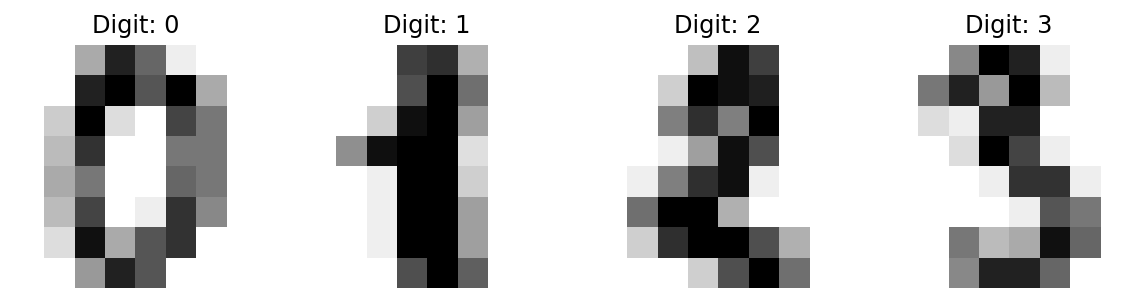

In [6]:
digits = load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Digit: %i" % label)

In [7]:
def generate_digits(n_samples):
    X, y = load_digits(n_class = 10, return_X_y = True)
    return X, y, "Digits" 

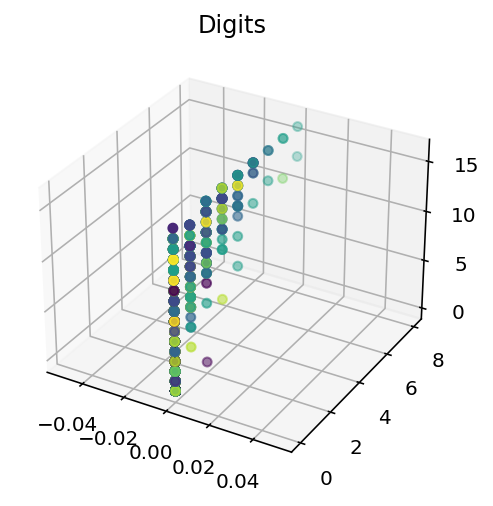

In [8]:
X, X_color, title = produce_plots_3D(generate_digits)

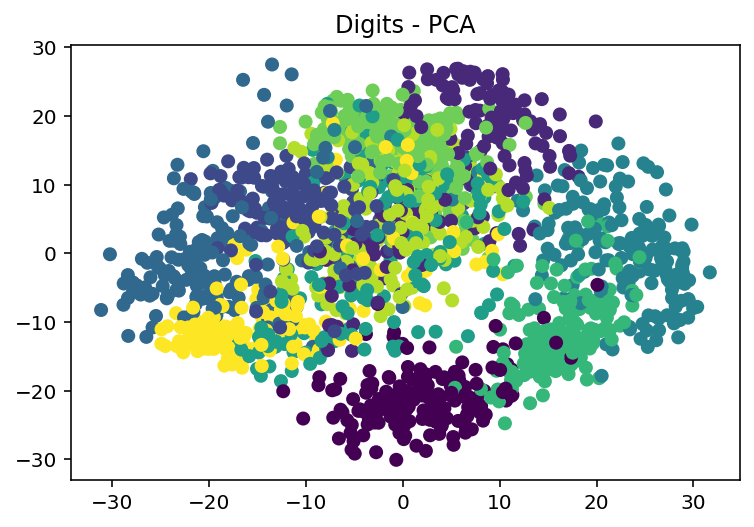

In [9]:
pca_plots_2d(X, X_color, title)

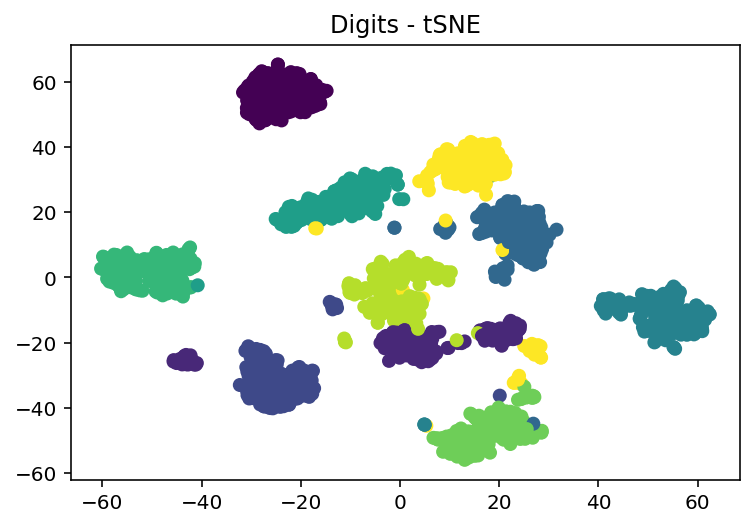

In [10]:
tsne_plots_2d(X, X_color, title)

# Observations
We can see that both methods (PCA and tSNE) result in different projections for the Digits Dataset. In this case, the tSNE algorithm seems to work better because it's able to cluster the data well. It's easier to distinguish the 10 different clusters (numbers 0 to 9) with the tSNE method. As opposed to PCA, tSNE is a non-linear technique. This allows the method to capture more complex relationships in the data. Furthermore, it's particularly effective at preserving the data's local structure, making it well-suited for visualizing high-dimensional data in 2D or 3D. Also, since the dataset is high-dimensional (the number of features per sample is the number of pixels per number) with close clusters, tSNE makes a better job at reducing the dimension. The figures above is are an example of this.

# Q3: Investigating the Role of the Perplexity in TSNE for the Long Clusters Dataset.
Implement the function `tsne_plots_perplexity` to iterate through the different values of perplexity. Observe and comment on the effect of the perplexity on the 2D TSNE visualization of the long clusters dataset. The long clusters dataset is composed of two clusters in 2D arranged in parallel line with some guassian noise. 

In [11]:
def generate_longclusters(): 

    x1 = np.asarray([i for i in range(-50, 50, 1)])
    x2 = np.asarray([i for i in range(-40, 60, 1)])
    y1 = x1 + np.random.normal(0, 3, 100)
    y2 = x2 + np.random.normal(-20, 3, 100)

    x1, x2 = np.expand_dims(x1, axis=1), np.expand_dims(x2, axis=1) 
    y1, y2 = np.expand_dims(y1, axis=1), np.expand_dims(y2, axis=1) 
    xy1, xy2 = np.concatenate((x1,y1), axis=1), np.concatenate((x2,y2), axis=1)
    xy = np.concatenate((xy1, xy2), axis=0)

    x1_color = [1] * 100 
    x2_color = [2] * 100 
    X_color = x1_color + x2_color
    
    plt.scatter(xy[:,0], xy[:,1], c=X_color)
    plt.title('long clusters')    
    plt.show()

    return xy, X_color, 'long clusters'

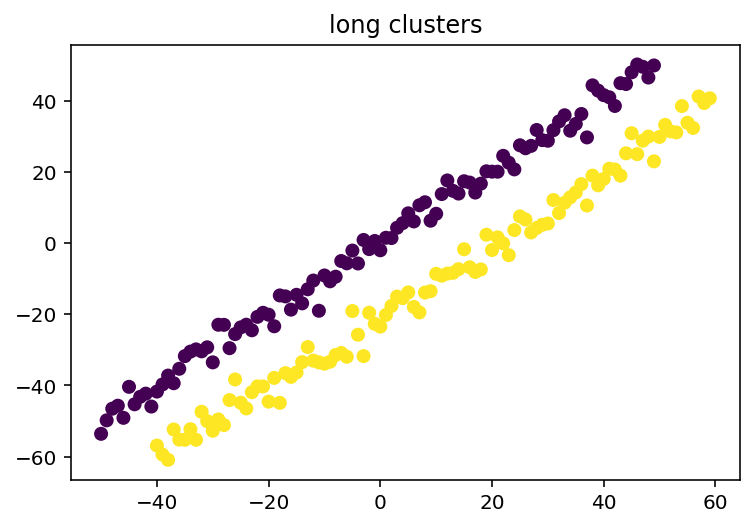

In [12]:
X, X_color, title = generate_longclusters()

In [13]:
def tsne_plots_perplexity(X, X_color, title): 
    # Start your implementation here!
    perplexities = np.linspace(0, 100, 11)
    plt.figure(figsize=(30, 20))
    plt.subplots_adjust(hspace=0.5)
    for n, perplexity in enumerate(perplexities):
        with warnings.catch_warnings(): 
            warnings.simplefilter("ignore",category=FutureWarning)
            X_tsne = TSNE(n_components=2, perplexity=perplexity).fit_transform(X)
        ax = plt.subplot(4, 3, n + 1)
        plot_data(X_tsne, X_color, title + " - perplexity = {}".format(int(perplexity)))
        

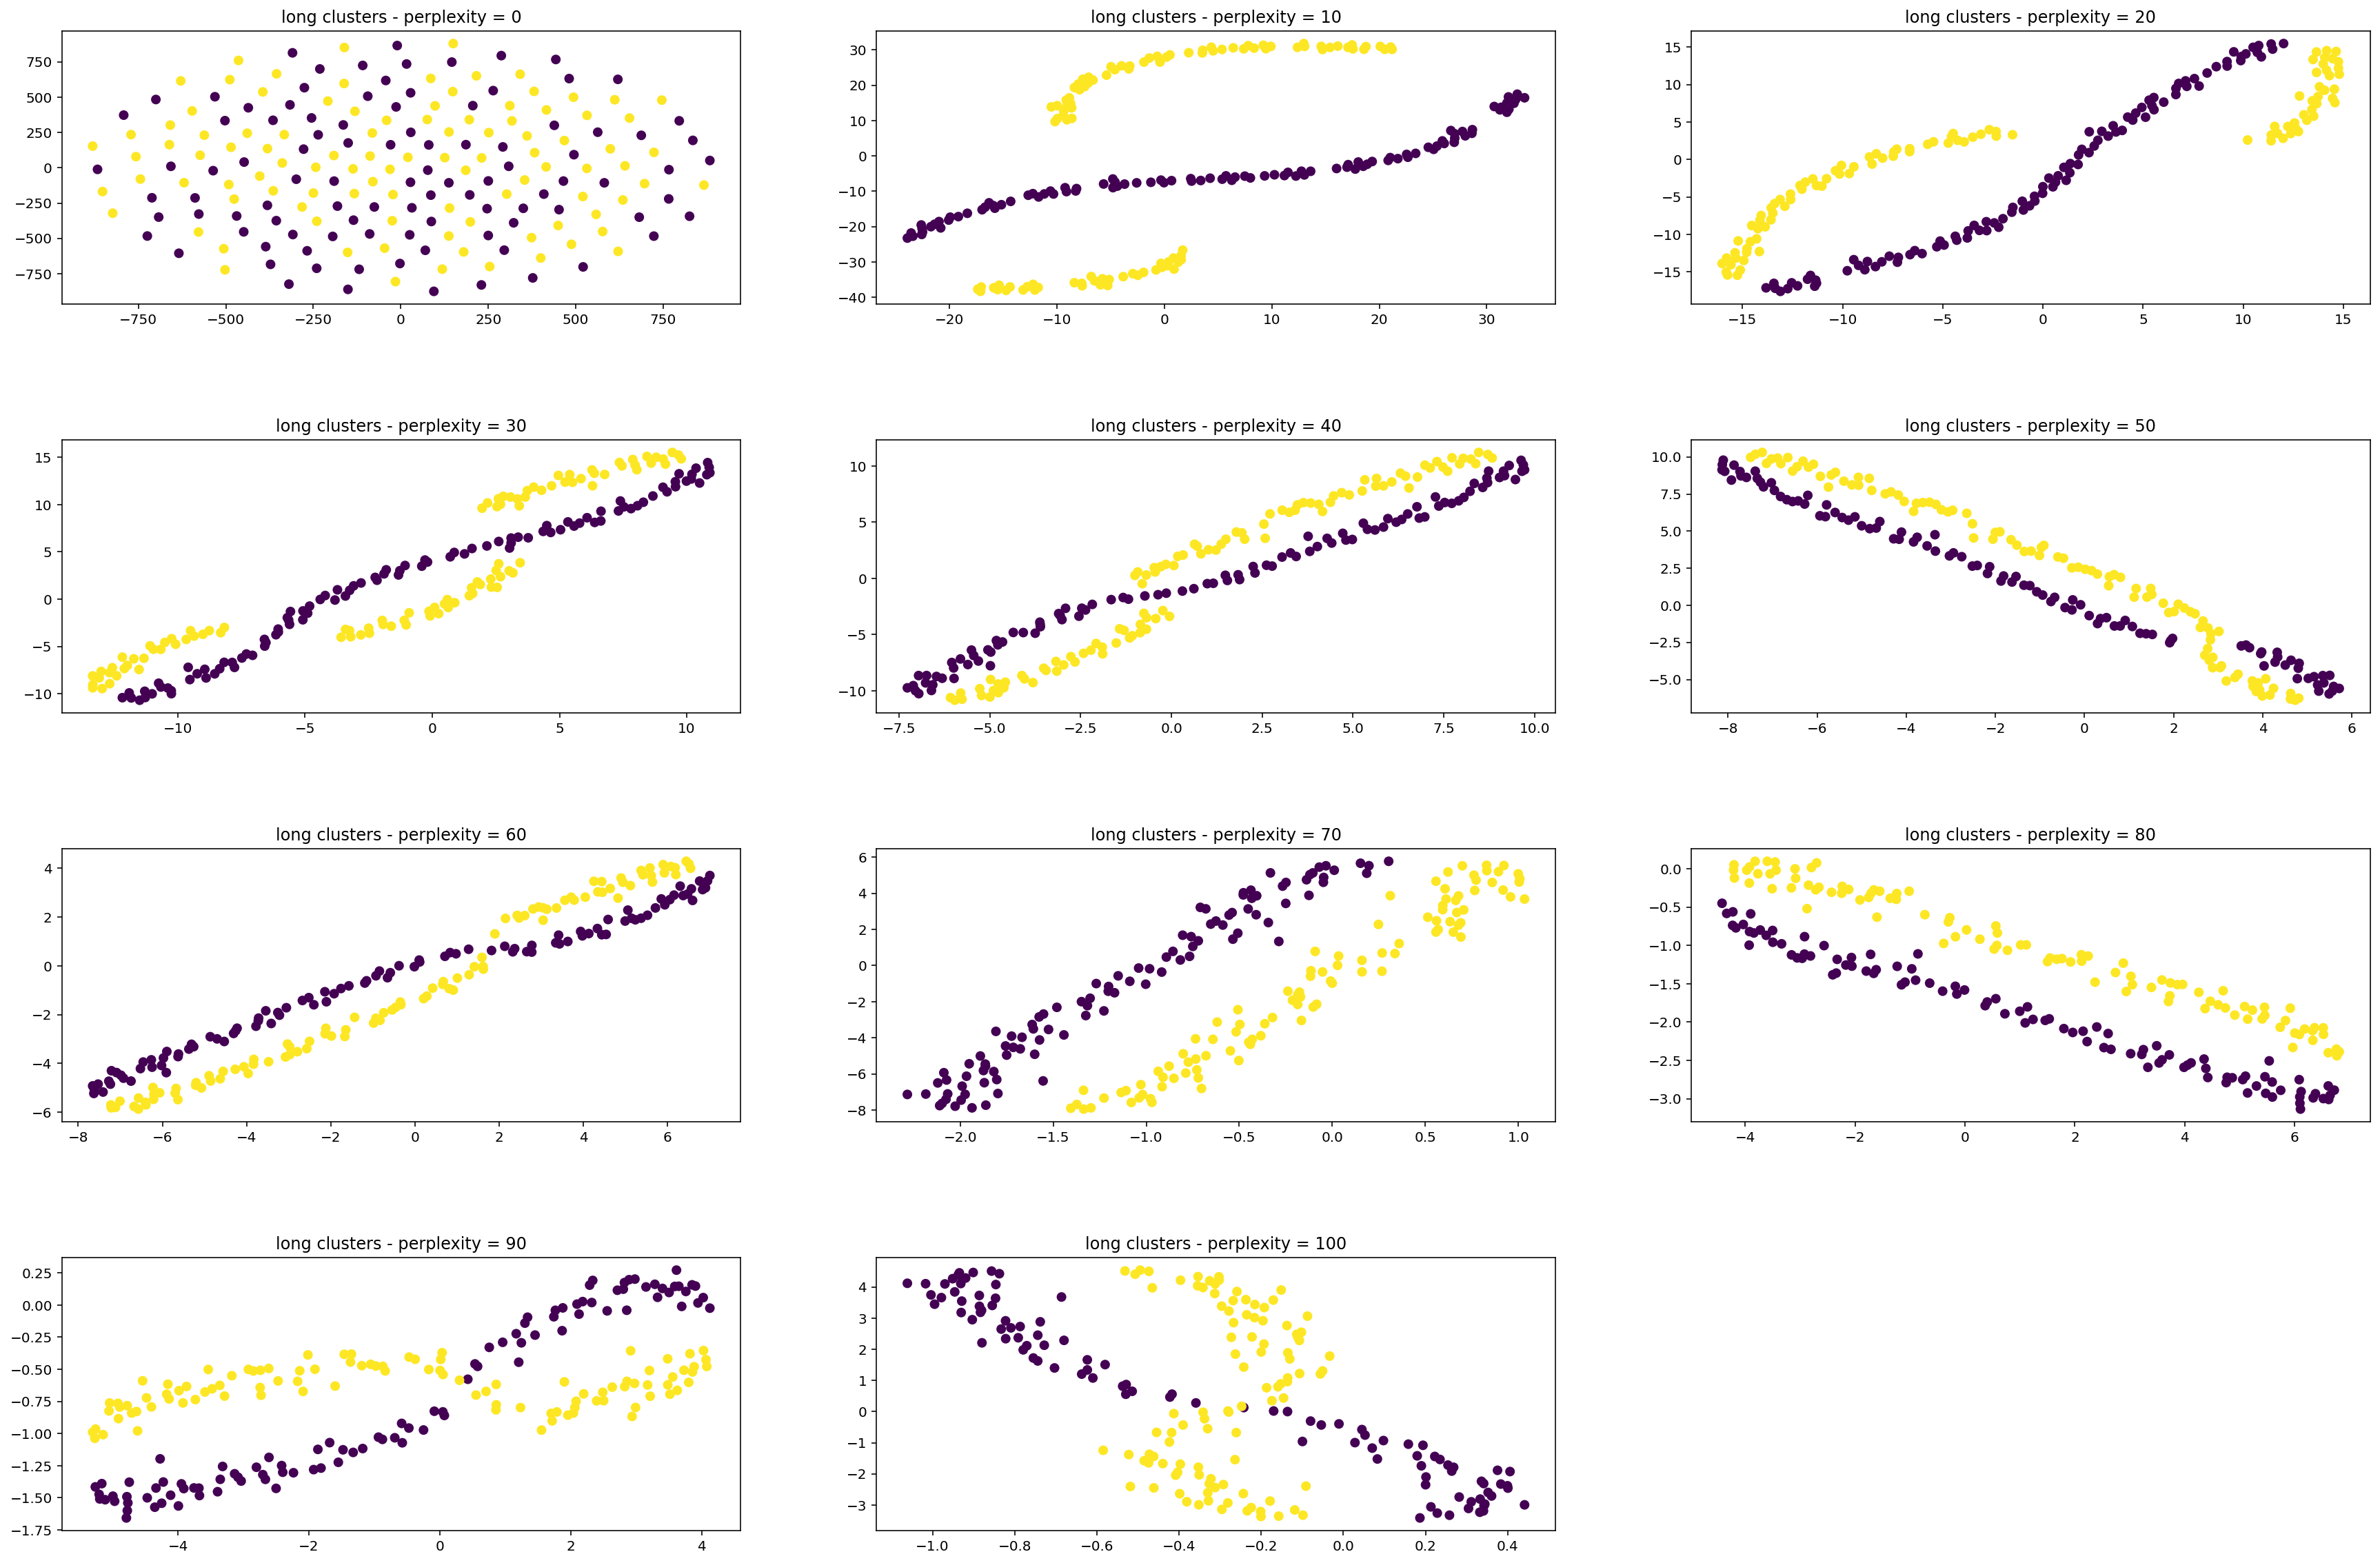

In [14]:
# run this cell to test your implementation! 
tsne_plots_perplexity(X, X_color, title)

# Observations 

Perplexity highly affects the 2D tSNE visualization. It can be seen that low perplexity values cause tSNE to focus more on preserving the local structure of the data, while high perplexity values cause tSNE to focus more on preserving the global structure of the data. We can also notice that a lot of points are closer to points in the other cluster than points in their own cluster, because of the elongated shape of the clusters. This causes the 2D visualization of the clusters to be curved and tangled for a lot of the perplexity values with tSNE. Generally speaking, we can see that local features are preserved, but that global features are typically not meaningful.

# Q4: PCA vs TSNE Reduction on Swiss_Roll Dataset 
Run the following cells. Compute and plot the 2-dimensional embedding generated by PCA and TSNE on the `Swiss_Roll` dataset. Describe your observations. Describe the pros and cons of each method.

In [15]:
def generate_swiss_roll_data(n_samples):
    noise = 0.05
    X, _ = make_swiss_roll(n_samples=n_samples, noise=noise)
    X[:, 1] *= .5
    distance_from_y_axis = X[:, 0] ** 2 + X[:, 2] ** 2 
    return X, distance_from_y_axis, "Swiss roll"

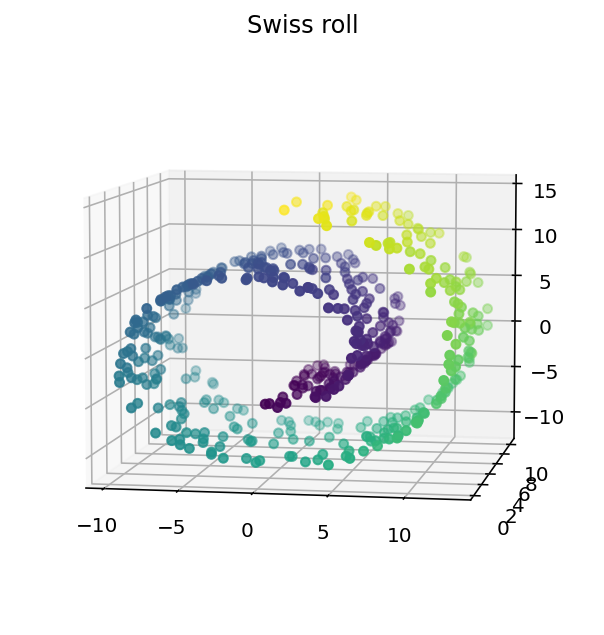

In [16]:
X, X_color, title = generate_swiss_roll_data(n_samples)

fig = plt.figure()
ax = fig.add_subplot(projection='3d', elev=7, azim=-80)
ax.set_position([0, 0, 0.95, 1])
ax.scatter(X[:,0], X[:,1], X[:,2], c=X_color)
plt.title(title)
plt.show()

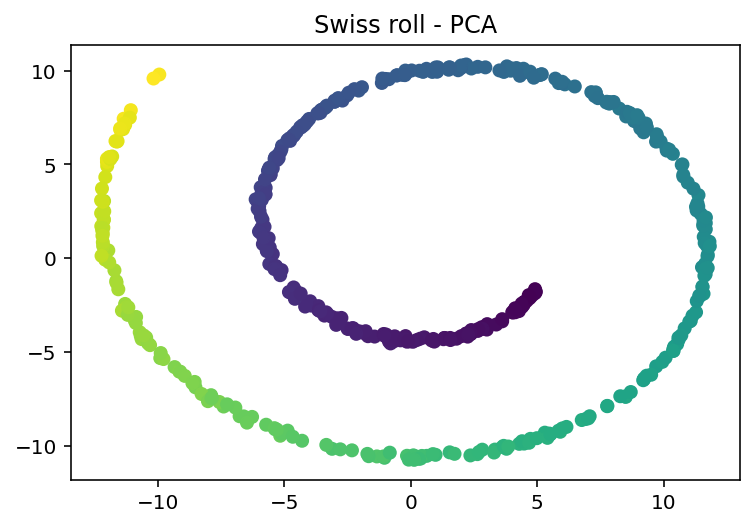

In [17]:
pca_plots_2d(X, X_color, title)

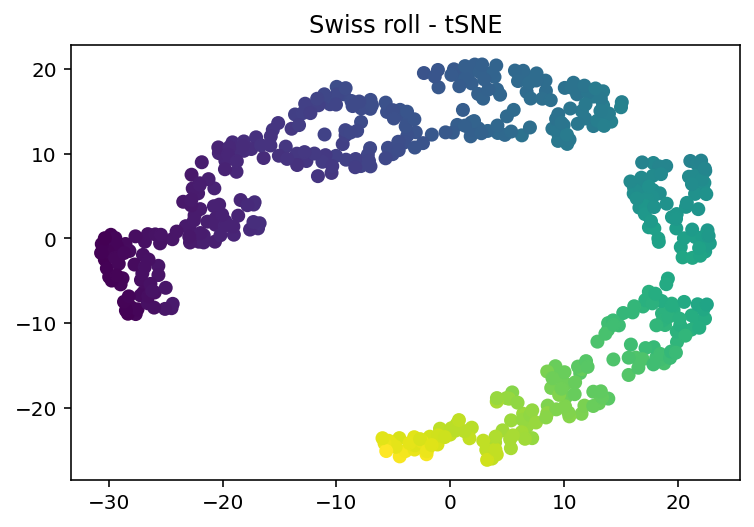

In [18]:
tsne_plots_2d(X, X_color, title)

# Observations

We can see that PCA has effectively captured the curl in the Swiss_Roll Dataset but that it has completely omitted one of the dimensions of the initial data. On the other hand, we can see that tSNE captures this third dimension by flattening the 3-dimensional Swiss Roll. Less data has been lost using tSNE. In this case, tSNE might be a better choice than PCA because the Swiss Roll Dataset is a non-linear dataset and tSNE is specifically designed to visualize non-linear data.

# Q5: TSNE perplexity for the Swiss Roll dataset

Run the following cell and describe the effect of perplexity on the Swiss Roll dataset for TSNE visualization. How would you choose the perplexity and why?

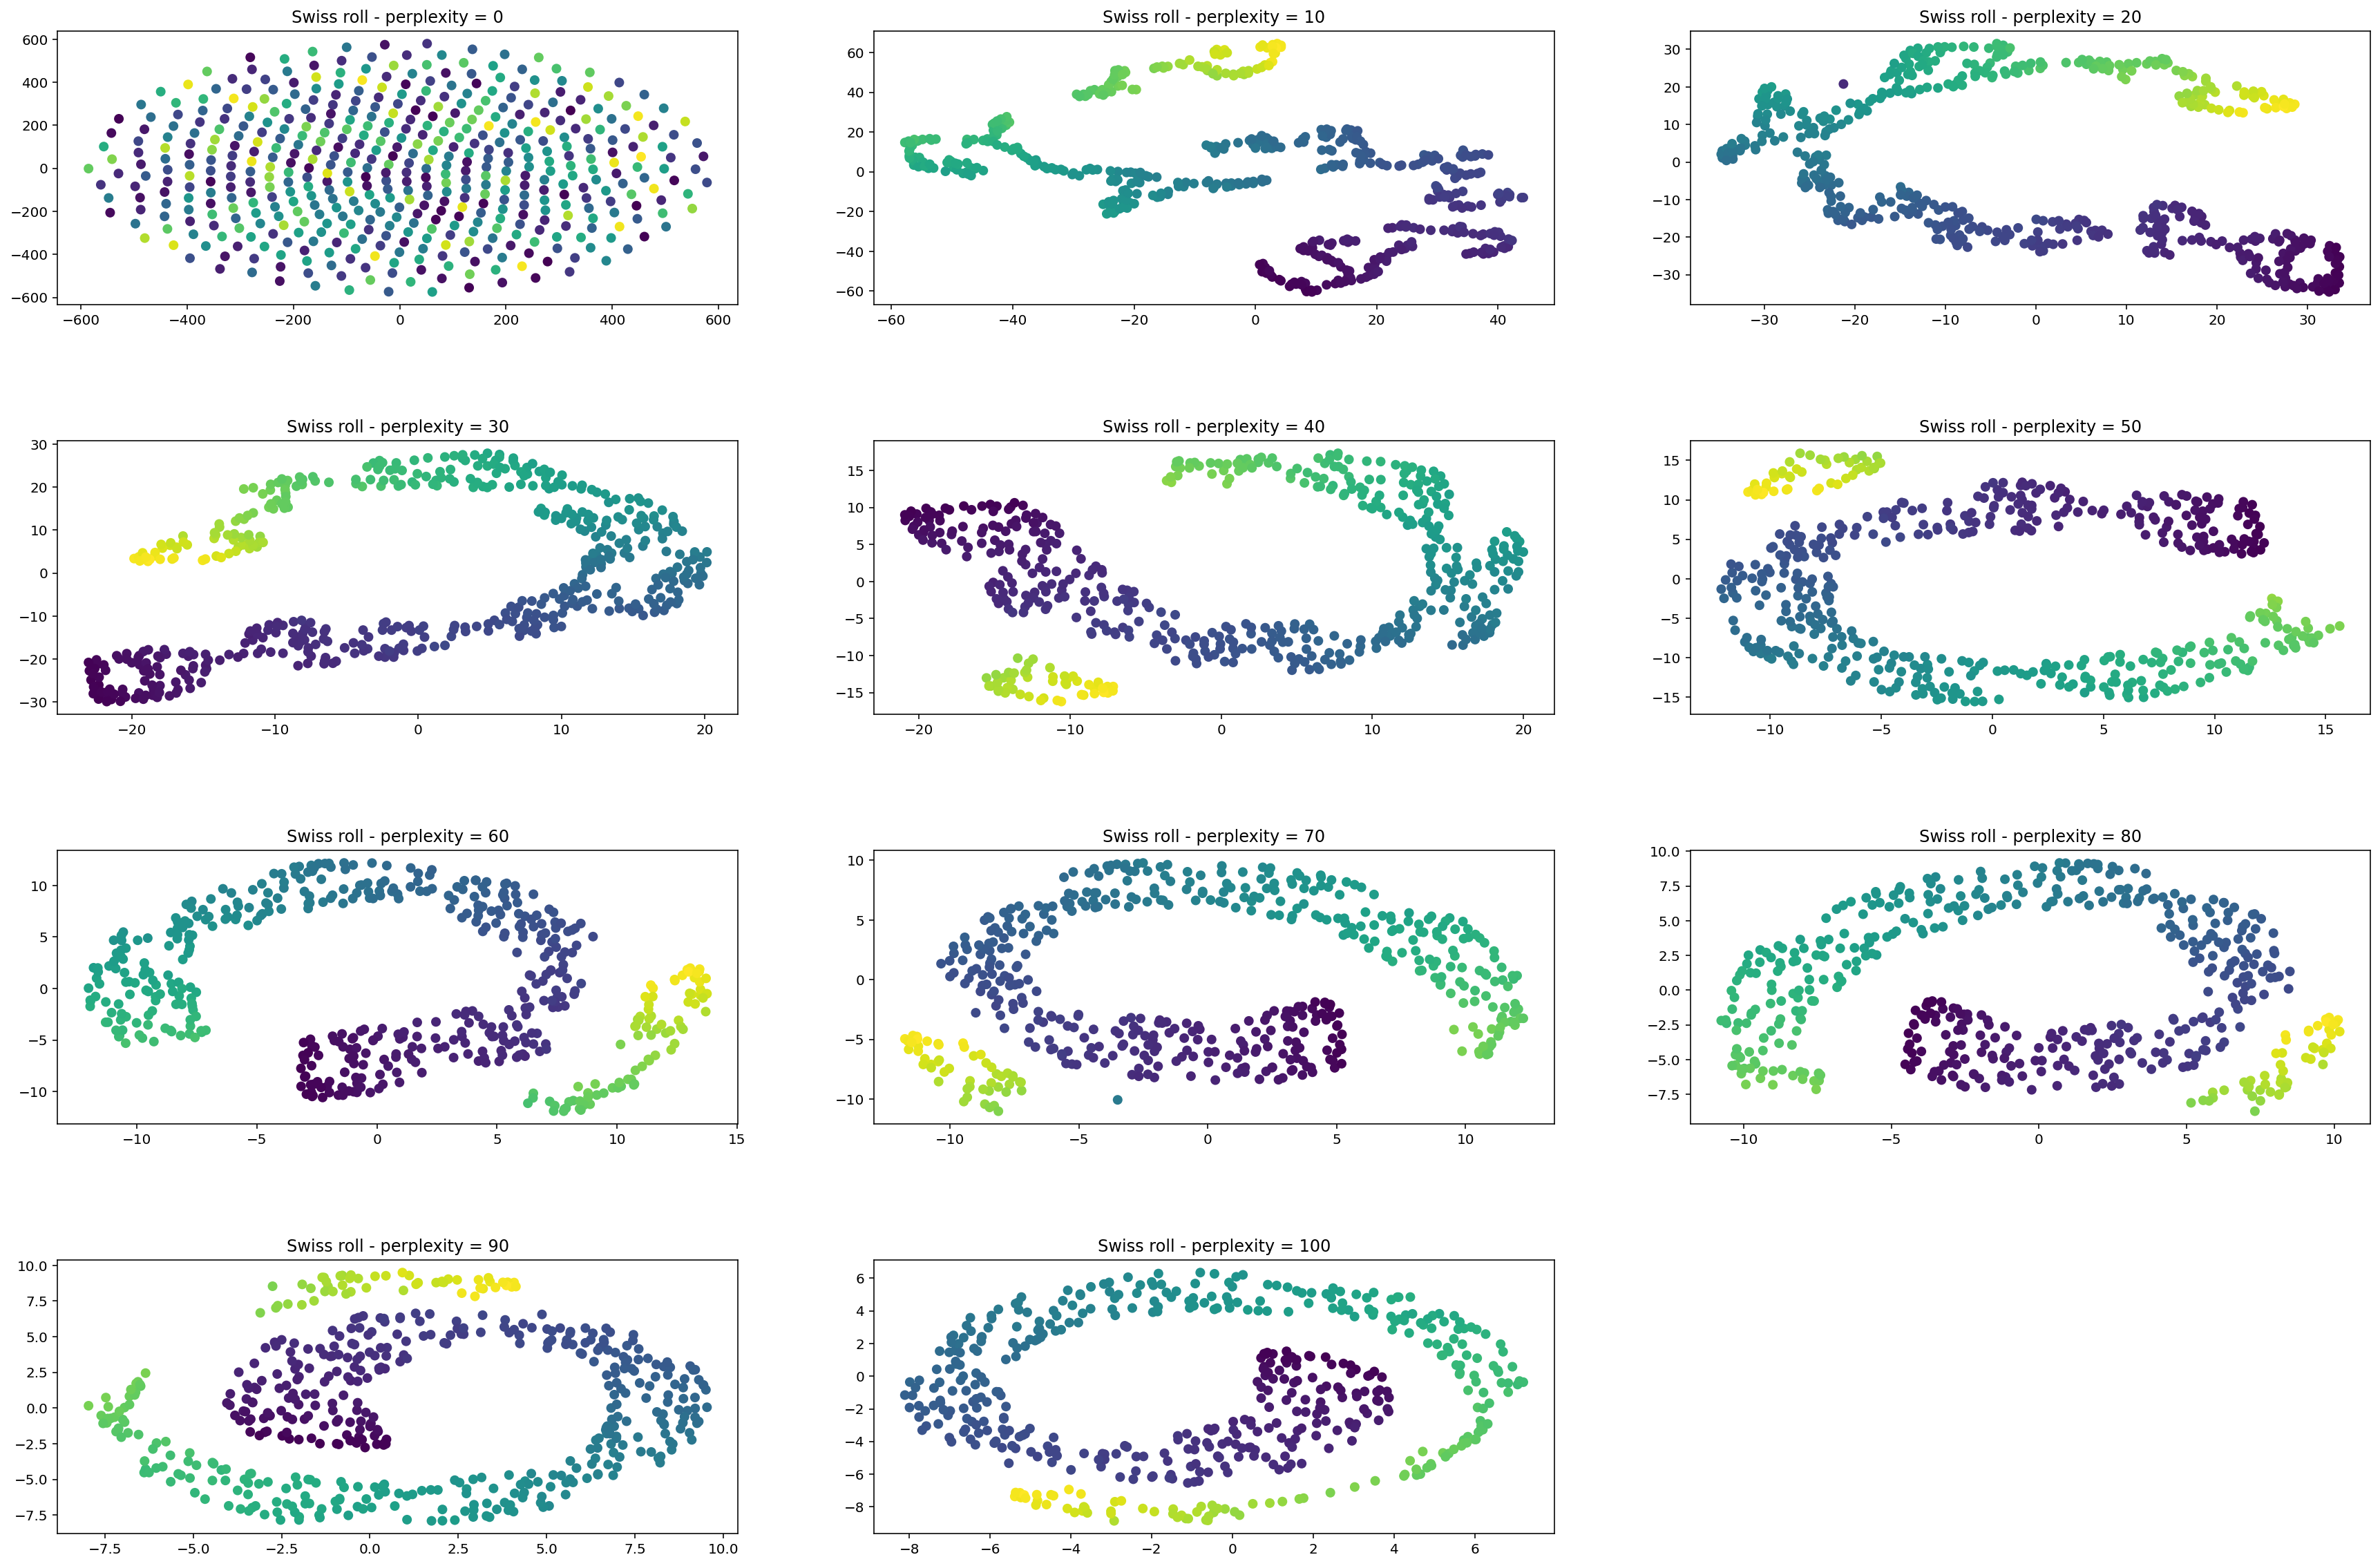

In [19]:
X, X_color, title = generate_swiss_roll_data(n_samples)
tsne_plots_perplexity(X, X_color, title)

# Observations

When perplexity is low, tSNE will tend to separate the points on the Swiss Roll Dataset into distinct clusters, with each cluster representing a small section of the roll. This will be useful for visualizing the local structure of the roll, such as small variations in the thickness of the roll, or the presence of small bumps or ridges. When perplexity is high, tSNE will tend to preserve more of the global structure of the data, showing the overall shape of the roll. This will be useful for visualizing the overall shape of the roll, such as its overall curvature and the location of its ends.

Choosing the perplexity for tSNE depends on the objective. There are multiple ways to find an optimal perplexity value. First, through trial and error. We can try different perplexity values, visualize the results, and visually inspect the figures to see which one best represents the structure of the Swiss Roll. Second, we can try using the elbow method, where we plot the Kullback-Leibler divergence against the perplexity and look for an "elbow" in the plot where the decrease in divergence starts to level off. We then choose the perplexity as the value corresponding to the elbow.

Ultimately, the optimal perplexity value is the one that best represents the structure of the data.

# Q6: PCA vs TSNE Reduction on Gaussian Blob Dataset 

You are given the following code to generate 6 Gaussian Blobs. Please run the following code to compute and plot the 2D projection generated by PCA and TSNE. Describe your observations. 

In [20]:
def generate_gaussian_blobs(n_samples):
    X, y = make_blobs(n_samples=n_samples, centers=6, n_features=3, random_state=3)
    return X, y, "Gaussian blobs" 

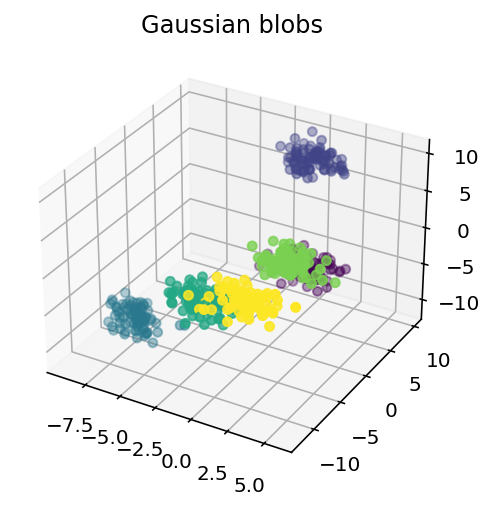

In [21]:
X, X_color, title = produce_plots_3D(generate_gaussian_blobs)

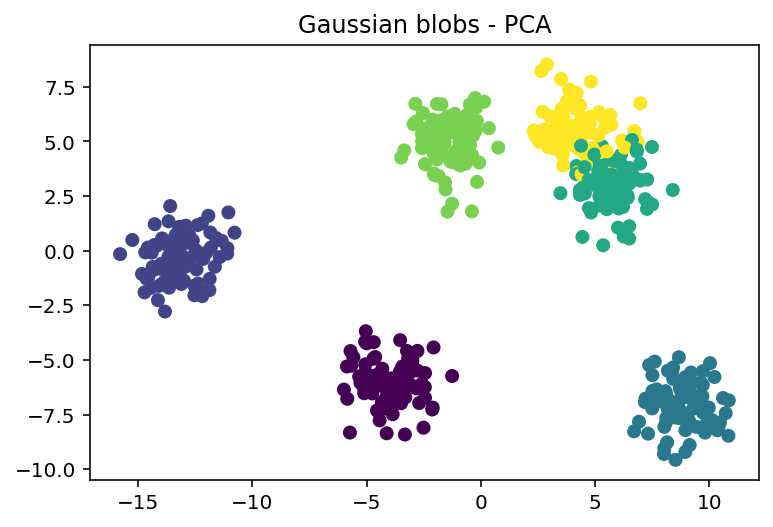

In [22]:
pca_plots_2d(X, X_color, title)

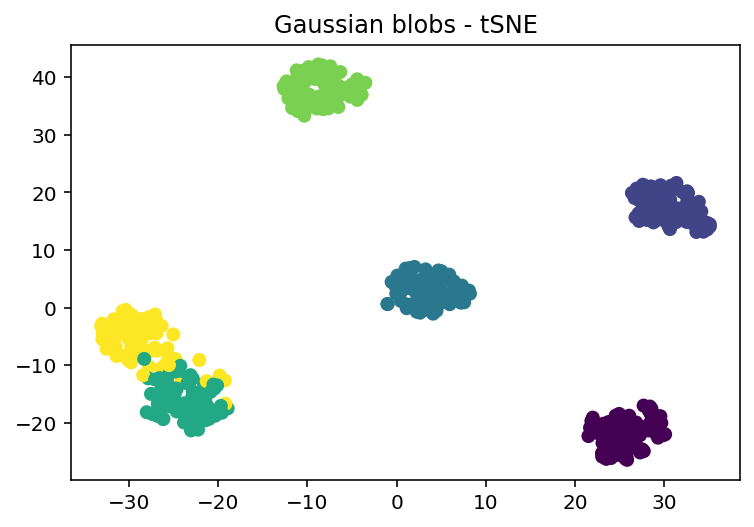

In [23]:
tsne_plots_2d(X, X_color, title)

# Observations

Both PCA and tSNE perform well on the Gaussian Blob Dataset. However, it can be seen that tSNE spreads out the clusters more in the low-dimensional space. tSNE tends to spread out clusters more than PCA, this makes it more suitable for datasets with many overlapping clusters.

# Q7: PCA vs TSNE Reduction on Gaussian Blob with different sizes

Based on the function `generate_gaussian_blobs` above, please implement the following function `generate_gaussian_blobs_diff_size`, so that two different Gaussian blobs are generated. The standard deviation (or the radius) of the first Gaussian blob should be three times that of the second Gaussian blob. Plot and comment on your results.

In [24]:
def generate_gaussian_blobs_diff_size(n_samples):
    X, y = make_blobs(n_samples=n_samples, centers=2, cluster_std=[3,1], n_features=3, random_state=3)
    return X, y, "Gaussian blobs"  

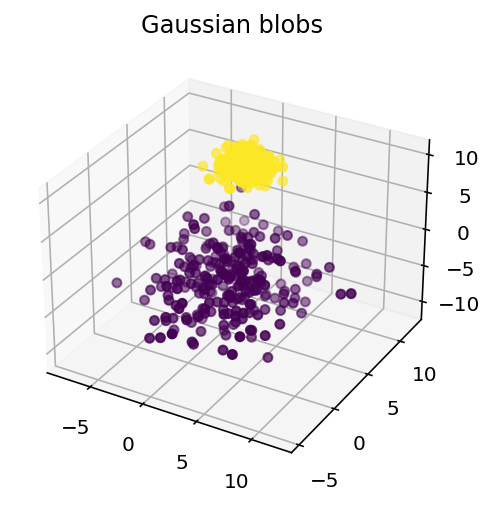

In [25]:
X, X_color, title = produce_plots_3D(generate_gaussian_blobs_diff_size)

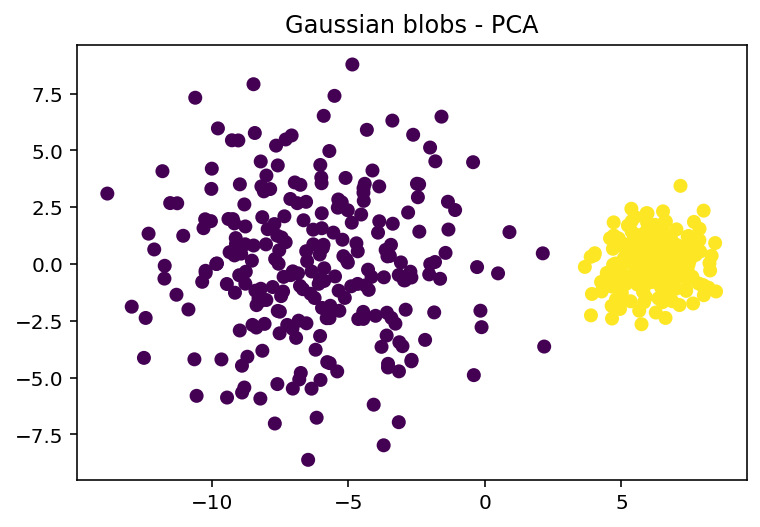

In [26]:
pca_plots_2d(X, X_color, title)

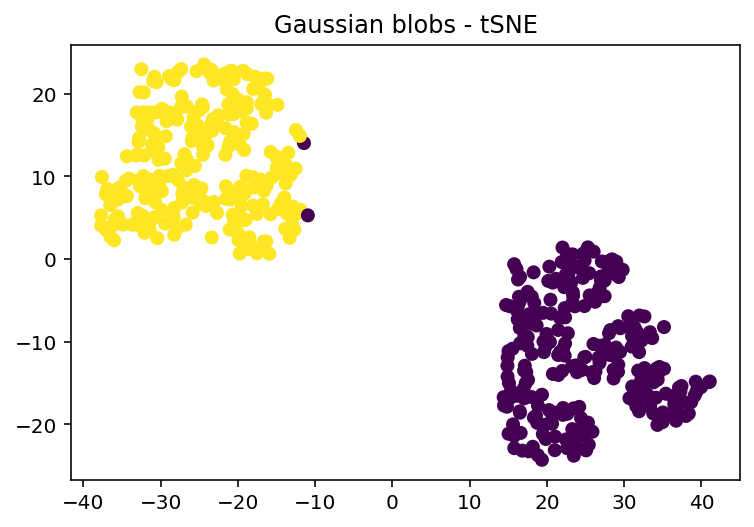

In [27]:
tsne_plots_2d(X, X_color, title)

# Observations

Wiht both methods, the clusters seem to be (almost) correctly identified. However, the geometry of the clusters is only preserved by PCA, not by tSNE.

# Q8: Effects of outliers on the 2D visualization using PCA and TSNE. 

Implement the following function `generate_gaussian_blobs_outliers(n_samples)` by modifying the function `generate_gaussian_blobs` so that there are 30 points randomly sampled in the space $([-50, 50], [-50, 50], [-50, 50])$. We consider those randomly generated points as outliers. 

Run the following cells and compare the effects of the outliers on the PCA and TSNE projections. 

In [28]:
def generate_gaussian_blobs_outliers(n_samples):
    X, y = make_blobs(n_samples=n_samples, centers=6, n_features=3, random_state=3)
    rand_X = 100*np.random.random((30,3))-50
    with warnings.catch_warnings(): 
        warnings.simplefilter("ignore",category=DeprecationWarning)
        new_y = 7*np.ones(30)
    X = np.concatenate((X,rand_X), axis=0)
    y = np.concatenate((y,new_y), axis=0)
    return X, y, "Gaussian blobs"

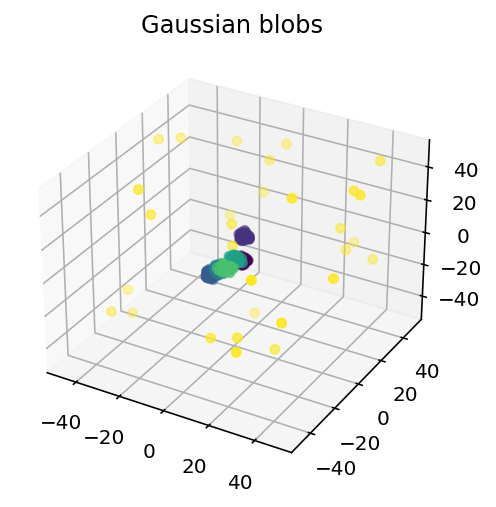

In [29]:
X, X_color, title = produce_plots_3D(generate_gaussian_blobs_outliers)

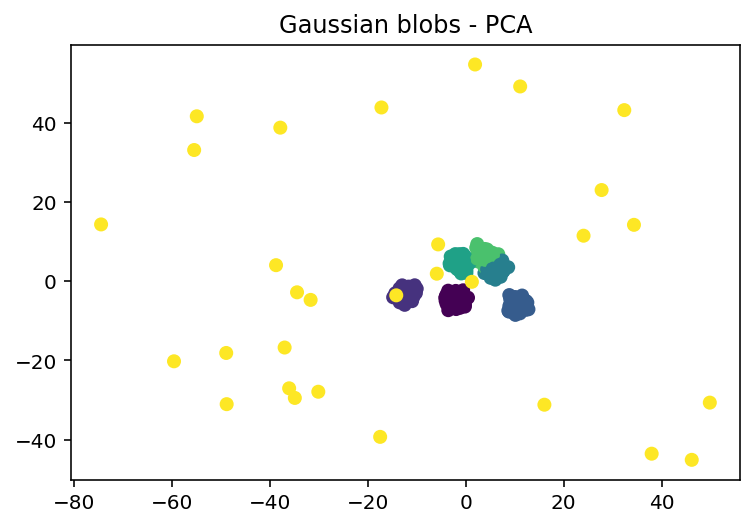

In [30]:
pca_plots_2d(X, X_color, title)

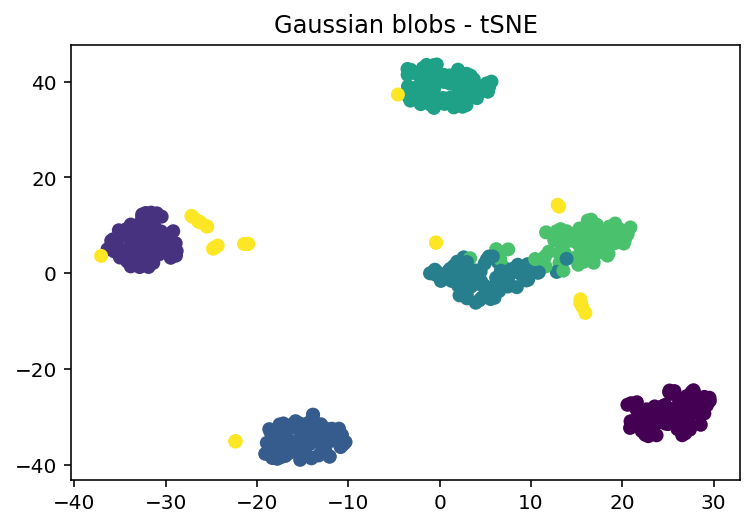

In [31]:
tsne_plots_2d(X, X_color, title)

# Observations

Both methods deal with outliers differently. In PCA, we can see that the outliers mainly remain far apart from the clusters. Which means that they're more likely to be indeed identified as outliers by clusterin algorithms later on. On the other hand, outliers are very close to the clusters in tSNE. This means that it's very likely thay clustering algorithms will incorrectly incorporate outliers into the clusters when clustering. Therefore, PCA seems to be a better method to deal with outliers. On the other hand, the clusters are very close to eachother in PCA, which can lead to difficulties later on in the clustering process.